# Try different hyperparameters of the TI9 dataset.

## Setup

In [1]:
import os
import sys

os.chdir("..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src import load, munge
import src.models.gp

In [53]:
import importlib
importlib.reload(src.load)
importlib.reload(src.munge)
importlib.reload(src.models.gp)

<module 'src.models.gp' from '/Users/yl3/github/dota2/src/models/gp.py'>

## Load data.

In [3]:
matches = load.all_matches_df()

In [4]:
matches_ti9 = matches.loc[matches.league_name == "The International 2019"]
matches_ti9.shape

(268, 15)

In [5]:
players_mat_ti9 = munge.make_match_players_matrix(
    matches_ti9.radiant_players, matches_ti9.dire_players)
players_mat_ti9.shape

(268, 240)

## Run model: very large covariance function scale.

In [8]:
twenty_years_in_ms = 20 * 365 * 24 * 60 * 60 * 1000

In [54]:
gp = src.models.gp.SkillsGP(players_mat_ti9.values,
                            matches_ti9.startTimestamp,
                            matches_ti9.radiantVictory,
                            matches_ti9.columns.values,
                            "exponential", {"scale": twenty_years_in_ms / 10},
                            propose_sd=0.1, save_every_n_iter=10)

In [55]:
gp.iterate(10000)

100% (10000 of 10000) |##################| Elapsed Time: 0:01:20 Time:  0:01:20


### Explore the fitted data.

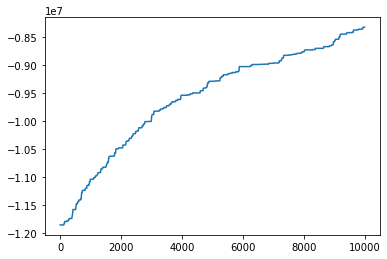

In [56]:
plt.plot([x[0] for x in gp.samples], [x[2] for x in gp.samples])

In [57]:
name_of_player_id = munge.player_id_to_player_name(
    pd.concat([matches_ti9.radiant_players, matches_ti9.dire_players]),
    pd.concat([matches_ti9.radiant_nicknames, matches_ti9.dire_nicknames]),
    pd.concat([matches_ti9.radiant_valveId, matches_ti9.dire_valveId]),
    pd.concat([matches_ti9.radiant_name, matches_ti9.dire_name]),)

In [58]:
name_of_player_id.loc[name_of_player_id.team.isin(["beastcoast"])]

,name,team,team_id
31818853,Brax,beastcoast,beastcoast
86715129,ixmike88,beastcoast,beastcoast
115141430,Ryoya,beastcoast,beastcoast
131706718,M-GOD,beastcoast,beastcoast
349310876,MoOz,beastcoast,beastcoast


In [59]:
skills_vecs = np.array([x[1] for x in gp.samples[-1000:]])

In [60]:
fitted_skills = pd.DataFrame(
    gp.to_mat(skills_vecs.mean(0)),
    columns=name_of_player_id.name[players_mat_ti9.columns],
    index=matches_ti9.startDate
)

In [61]:
fitted_sd = pd.DataFrame(
    gp.to_mat(skills_vecs.std(0)),
    columns=name_of_player_id.name[players_mat_ti9.columns],
    index=matches_ti9.startDate
)

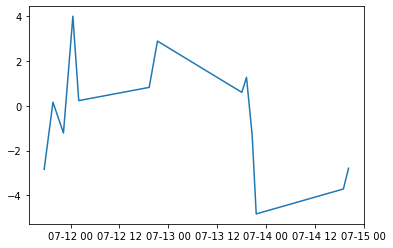

In [62]:
beastcoast_players = \
    name_of_player_id.name[name_of_player_id.team == "beastcoast"]
plt.plot(fitted_skills.loc[:, beastcoast_players].dropna().sum(1))

In [63]:
(fitted_sd.loc[:, beastcoast_players].dropna() ** 2).sum(1) ** 0.5

startDate
2019-07-14 20:18:11    0.870360
2019-07-14 19:02:07    1.342075
2019-07-13 21:37:01    1.083105
2019-07-13 20:37:17    1.003351
2019-07-13 19:13:43    1.110301
2019-07-13 18:04:37    0.760853
2019-07-12 21:20:54    0.860079
2019-07-12 19:18:44    0.716367
2019-07-12 02:00:18    0.885200
2019-07-12 00:33:39    0.895704
2019-07-11 22:14:41    1.261970
2019-07-11 19:40:06    0.851157
2019-07-11 17:30:21    1.152352
dtype: float64

### How do the covariance matrices look like?

In [64]:
name_of_player_id.loc[name_of_player_id.name == "ixmike88"]

,name,team,team_id
86715129,ixmike88,beastcoast,beastcoast


In [65]:
gp.cov_mat[players_mat_ti9.columns == "86715129"]

array([[1.        , 0.99988999, 0.99980703, 0.99888537, 0.99869278,
        0.99861855, 0.99843687],
       [0.99988999, 1.        , 0.99991703, 0.99899527, 0.99880266,
        0.99872842, 0.99854672],
       [0.99980703, 0.99991703, 1.        , 0.99907816, 0.99888553,
        0.99881129, 0.99862957],
       [0.99888537, 0.99899527, 0.99907816, 1.        , 0.99980719,
        0.99973288, 0.999551  ],
       [0.99869278, 0.99880266, 0.99888553, 0.99980719, 1.        ,
        0.99992568, 0.99974375],
       [0.99861855, 0.99872842, 0.99881129, 0.99973288, 0.99992568,
        1.        , 0.99981807],
       [0.99843687, 0.99854672, 0.99862957, 0.999551  , 0.99974375,
        0.99981807, 1.        ]])

### What is the observed and expected outcome?

In [67]:
win_prob = src.models.gp.compute_match_win_prob(players_mat_ti9,
                                                gp.to_mat(gp.samples[-1][1]))

In [71]:
matches_ti9.loc[:, 'win_prob'] = win_prob
matches_ti9.loc[:, ['win_prob', 'radiantVictory']]

,win_prob,radiantVictory
matchId,,
4904311356,0.728454,False
4904261164,0.416905,True
4904218149,0.543742,False
4904171017,0.192231,False
4904062522,0.395476,False
4903974414,0.529263,False
4903679968,0.296984,True
4903566049,0.306126,False
4903441151,0.548804,True


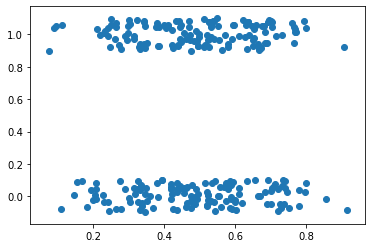

In [73]:
plt.scatter(matches_ti9.win_prob,
            matches_ti9.radiantVictory + np.random.uniform(size=matches_ti9.shape[0]) / 5 - .1)

## Test the basic win probability functionality.

In [74]:
src.models.gp.win_prob(2)  # Should be around 60%

0.598687660112452

In [75]:
src.models.gp.win_prob(0)  # Should be 50%

0.5

In [76]:
src.models.gp.win_prob(10) # 85-90%

0.8807970779778823

## Do the likelihoods come from prior or posterior?

Answer: they come from the priors...

In [77]:
[(x[3], x[4]) for x in gp.samples[-100:]]

[(-8666007.033048784, -209.1112987825406),
 (-8773632.863779567, -208.24574979390542),
 (-8632879.037117707, -207.7412353093519),
 (-8596573.087223882, -207.12395891807654),
 (-8652270.977072477, -207.8994752410528),
 (-8660650.221291479, -208.59300403989093),
 (-8711442.284397105, -207.31027581086224),
 (-8614654.899382135, -207.95364282345093),
 (-8642105.351620544, -207.21304608780852),
 (-8715159.786720267, -206.2818343103167),
 (-8600567.954793764, -207.52519468328344),
 (-8641622.397585122, -208.35400170202405),
 (-8589552.08277977, -208.2255006327827),
 (-8617344.783700045, -209.35591858305523),
 (-8685341.563909117, -208.12254425495846),
 (-8622978.625963442, -207.87135997337055),
 (-8621614.950165551, -207.3892357568691),
 (-8560642.404977897, -207.34331592477832),
 (-8680050.494517116, -207.0099056177287),
 (-8447806.862071835, -206.76854271841742),
 (-8598137.476525733, -207.51805013600216),
 (-8533207.391164461, -206.78198522198855),
 (-8519337.62231253, -206.42845111320938

## Can we initialise using BFBS?

In [78]:
import scipy.optimize

In [80]:
scipy.optimize.minimize(lambda x: -gp.compute_log_posterior(x),
                        np.repeat(0.0, gp.M * 10),
                        method = "BFGS")

KeyboardInterrupt: 